In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

sns.set_style('whitegrid')

In [2]:
pd.options.display.max_rows=250
pd.options.display.max_columns=250

# Problem definition

Cluster museums based on traveler type and tags, in order to recommend types of museums to visit (i.e. which categories).

# Load the data

In [3]:
#input
df = pd.read_csv('data/museum_data.csv')
df = df.set_index(['MuseumName', 'Continent', 'SubRegion','Country'])
df.head()
df_copy = df.copy()

# Feature Engineering 

In [4]:
# define columns ranges
traveler_columns = ['Families', 'Couples', 'Solo', 'Business', 'Friends']
categories = list(df.loc[:,'Ancient Ruins':'Zoos & Aquariums'].columns)
tags = list(df.loc[:,'on display':'life size'].columns)

# instead of looking at the ratios of traveler types, identify the top traveler type per museum, because that can be used as a selector in the app
df['TopTraveler'] = df[traveler_columns].idxmax(axis=1)
df_top_travelers = df['TopTraveler'].str.get_dummies()
df_top_travelers.columns = ['TopCouples','TopFamilies','TopFriends','TopSolo']
df = pd.concat([df, df_top_travelers], axis=1)

C:\Users\Kirsten\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [6]:
# convert tags data to ints so logical comparisons work properly
df.loc[:,tags] = df.loc[:,tags].astype(int)

# create combinations of similar tags to reduce dimensionality
df['special exhibit'] = (df['special exhibits']) | (df['special exhibitions']) | (df['traveling exhibits']) | (df['changing exhibits']) | (df['rotating exhibits'])
df['interactive'] = (df['interactive exhibits']) | (df['interactive displays']) | (df['hands on activities'])
df['family'] = (df['all ages']) | (df['great for kids']) | (df['whole family']) | (df['kids and adults'])
df['art'] = (df['art lovers']) | (df['works of art']) | (df['modern art']) | (df['old masters']) | (df['sculpture garden'])
df['learn'] = (df['great place to learn']) | (df['learn something'])
df['display'] = (df['on display']) | (df['displays'])
df['history2'] = (df['old west']) | (df['early days']) | (df['interesting artifacts']) | (df['history lesson']) | (df['history buff']) | (df['lots of history']) | (df['great history'])
df['natural'] = (df['natural history']) | (df['stuffed animals'])

## other features I tried that weren't helpful in the end:
# df['2 hours'] = (df['couple of hours']) | (df['few hours']) | (df['two hours'])
# df['audio'] = (df['audio guide']) | (df['audio tour'])
# df['free'] = (df['free admission']) | (df['free entry']) | -(df['entrance fee']) | -(df['admission'])
# df['collection'] = (df['private collection']) | (df['amazing collection']) | (df['nice collection']) | (df['permanent collection'])
# df['Popular'] = (df['ReviewCount']>10000)

In [9]:
# remove NaNs
df = df.dropna()

# select the columns
tags_to_use = ['special exhibit', 'interactive', 'family', 'audio guide', 'art', 'display', 'rainy day', 'natural', 'eye opening', 'learn', 'history2', 'permanent collection']
numeric_columns = ['ReviewCount', 'Rating','TopCouples','TopFamilies','TopFriends','TopSolo']

X_columns = tags_to_use + numeric_columns
df = df[X_columns]

# normalize the columns
df_norm = df.copy()
for col in X_columns:
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))

print(df.shape)
df_norm.head()

(1593, 18)


C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was

,,,,special exhibit,interactive,family,audio guide,art,display,rainy day,natural,eye opening,learn,history2,permanent collection,ReviewCount,Rating,TopCouples,TopFamilies,TopFriends,TopSolo
MuseumName,Continent,SubRegion,Country,,,,,,,,,,,,,,,,,,
The Field Museum,Americas,Northern America,USA,2.218543,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,1.012232,0.255839,-1.438528,1.545756,-0.160489,-0.075378
Smithsonian National Museum of Natural History,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,1.559032,0.255839,-1.438528,1.545756,-0.160489,-0.075378
American Museum of Natural History,Americas,Northern America,USA,2.218543,-0.443672,-0.513111,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,3.182058,0.255839,-1.438528,1.545756,-0.160489,-0.075378
National Naval Aviation Museum,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,0.643525,2.012523,-1.438528,1.545756,-0.160489,-0.075378
National Mississippi River Museum & Aquarium,Americas,Northern America,USA,-0.450746,2.253919,1.948895,-0.321225,-0.344499,0.998119,-0.462792,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-0.128383,0.255839,-1.438528,1.545756,-0.160489,-0.075378


# Model Training

In [10]:
k = 8
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

{0, 1, 2, 3, 4, 5, 6, 7}
Counter({1: 701, 7: 270, 2: 173, 5: 162, 0: 133, 6: 80, 4: 39, 3: 35})


In [11]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(kmeans.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['SubRegion']).most_common(5))

# n_clusters = len(set(kmeans.labels_))
# for col in X_columns:
#     print(col)
#     i = 1
#     plt.figure(figsize=(16,3))
#     for cluster in sorted(set(kmeans.labels_)):
#         plt.subplot(1, n_clusters, i)
#         plt.xlim([0,df_results[col].max()])
#         plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
#         i += 1
#     plt.show()

[('Western Europe', 46), ('Southern Europe', 27), ('Eastern Asia', 11), ('Northern Europe', 11), ('Eastern Europe', 10)]
[('Northern America', 426), ('Northern Europe', 68), ('Southern Europe', 54), ('Western Europe', 53), ('Eastern Europe', 26)]
[('Northern America', 140), ('Northern Europe', 13), ('Western Europe', 9), ('Eastern Asia', 5), ('Australia and New Zealand', 3)]
[('Northern America', 19), ('South-eastern Asia', 5), ('Eastern Europe', 4), ('Western Europe', 3), ('Latin America and the Caribbean', 2)]
[('Northern America', 19), ('South-eastern Asia', 4), ('Eastern Asia', 4), ('Western Asia', 3), ('Northern Europe', 3)]
[('Northern America', 139), ('Western Europe', 12), ('Northern Europe', 5), ('Latin America and the Caribbean', 3), ('Eastern Asia', 2)]
[('Northern America', 47), ('Northern Europe', 15), ('Western Europe', 7), ('Australia and New Zealand', 4), ('Eastern Europe', 2)]
[('Northern America', 220), ('Northern Europe', 14), ('Western Europe', 8), ('South-eastern A

In [23]:
# add the clusters to the original dataset in order to analyze the museum categories in each cluster
df_copy = pd.concat([df_copy.reset_index(),df_results['cluster']],axis=1)

# count the number of museums of each category per cluster
df_cluster_categories = df_copy.groupby('cluster')[categories].sum().T

# print the top museum categories and frequency per cluster
for i in range(8):
    print('Cluster',i)
    print(df_cluster_categories[i].sort_values(ascending=False).head(10))
    print('')

Cluster 0
Museums                           131
Specialty Museums                  70
Art Museums                        42
History Museums                    36
Sights & Landmarks                 19
Historic Sites                     12
Points of Interest & Landmarks      7
Military Museums                    5
Sacred & Religious Sites            3
Architectural Buildings             2
Name: 0, dtype: int64

Cluster 1
Museums                           672
Specialty Museums                 429
History Museums                   211
Art Museums                       105
Sights & Landmarks                 71
Historic Sites                     39
Military Museums                   30
Nature & Parks                     19
Points of Interest & Landmarks     18
Traveler Resources                 12
Name: 1, dtype: int64

Cluster 2
Museums                         171
Specialty Museums                80
Science Museums                  45
History Museums                  32
Children's Museums  

In [15]:
# normalize the results
df_results_norm = df_results.copy()
for col in X_columns:
    df_results_norm[col] = StandardScaler().fit_transform(df_results_norm[col].values.reshape(-1, 1))

print(df.shape)
df_norm.head()

(1593, 18)


C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was

,,,,special exhibit,interactive,family,audio guide,art,display,rainy day,natural,eye opening,learn,history2,permanent collection,ReviewCount,Rating,TopCouples,TopFamilies,TopFriends,TopSolo,cluster
MuseumName,Continent,SubRegion,Country,,,,,,,,,,,,,,,,,,,
The Field Museum,Americas,Northern America,USA,2.218543,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,1.012232,0.255839,-1.438528,1.545756,-0.160489,-0.075378,6
Smithsonian National Museum of Natural History,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,1.559032,0.255839,-1.438528,1.545756,-0.160489,-0.075378,6
American Museum of Natural History,Americas,Northern America,USA,2.218543,-0.443672,-0.513111,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,3.182058,0.255839,-1.438528,1.545756,-0.160489,-0.075378,7
National Naval Aviation Museum,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,0.643525,2.012523,-1.438528,1.545756,-0.160489,-0.075378,7
National Mississippi River Museum & Aquarium,Americas,Northern America,USA,-0.450746,2.253919,1.948895,-0.321225,-0.344499,0.998119,-0.462792,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-0.128383,0.255839,-1.438528,1.545756,-0.160489,-0.075378,2


In [17]:
# Analyze the normalized centroids
df_results_norm.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4,5,6,7
special exhibit,-0.25,-0.23,-0.07,-0.45,-0.11,1.58,0.18,-0.17
interactive,-0.26,-0.23,2.25,-0.06,-0.37,-0.41,0.03,-0.41
family,-0.48,-0.33,1.58,-0.51,-0.45,-0.50,0.96,0.23
audio guide,2.98,-0.32,-0.32,0.17,0.03,-0.15,-0.15,-0.32
art,0.68,-0.15,-0.33,-0.34,-0.01,1.10,-0.30,-0.27
display,0.16,-0.03,-0.41,-0.26,-0.59,0.50,-0.00,0.07
rainy day,-0.05,-0.05,0.42,-0.39,-0.40,-0.09,0.69,-0.14
natural,-0.23,-0.23,-0.23,-0.23,-0.23,-0.23,4.35,-0.23
eye opening,-0.15,-0.15,-0.15,6.67,-0.15,-0.15,-0.15,-0.15
learn,-0.16,0.00,0.23,-0.05,-0.20,-0.20,0.06,0.06


special exhibit


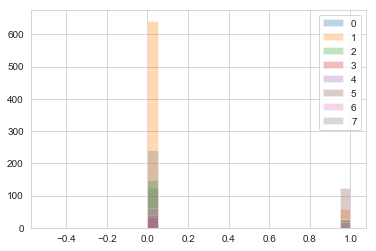

interactive


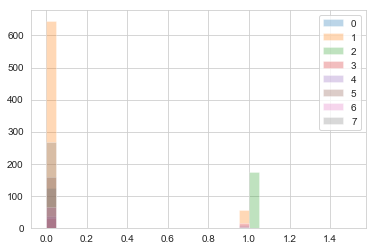

family


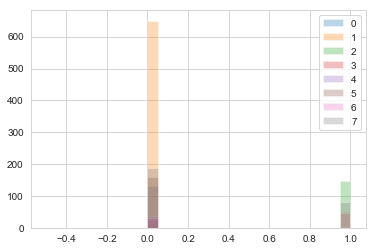

audio guide


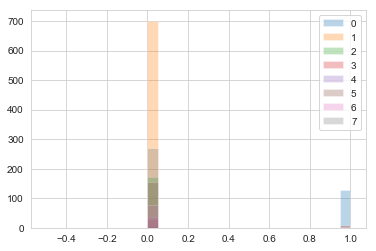

art


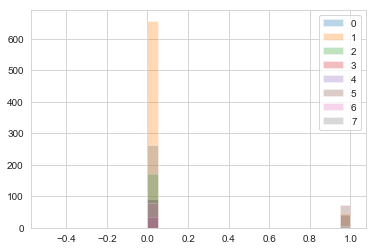

display


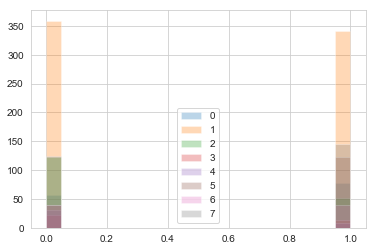

rainy day


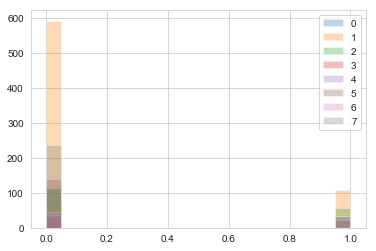

natural


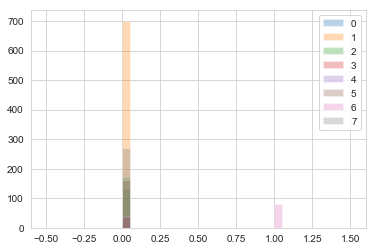

eye opening


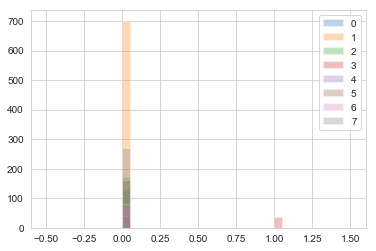

learn


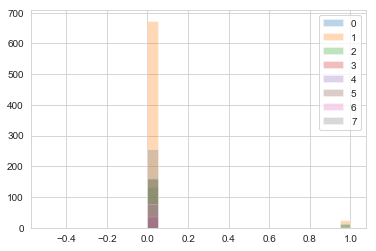

history2


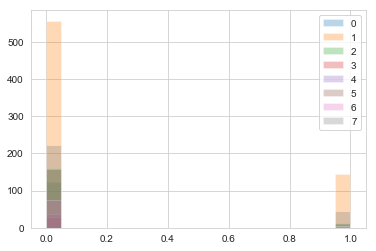

permanent collection


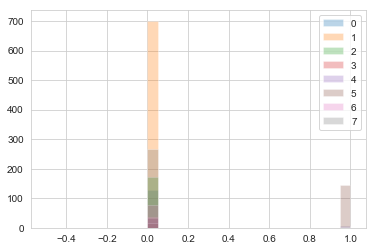

ReviewCount


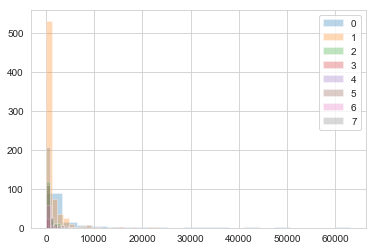

Rating


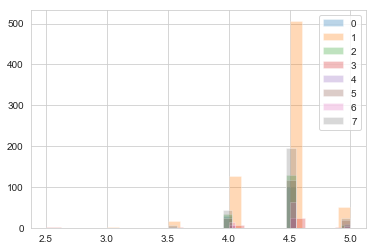

TopCouples


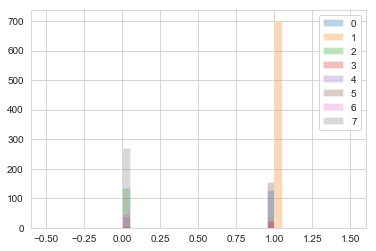

TopFamilies


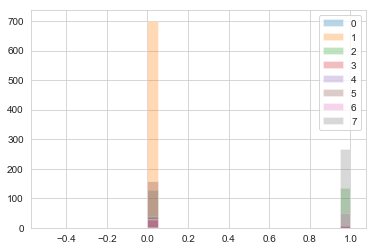

TopFriends


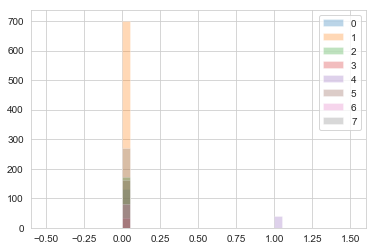

TopSolo


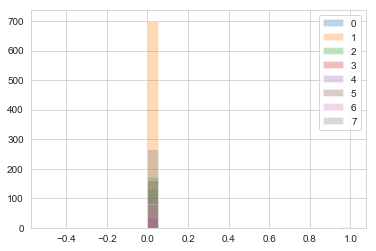

In [18]:
# Analyze the results
for col in X_columns:
    print(col)
    for cluster in set(kmeans.labels_):
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
    plt.legend()
    plt.show()

Based on the normalized results, and the types of museums within each cluster, the clusters appear to defined by the following:

0: highly popular art museums with an audio guide, but no permanent collections/special exhibits (not family friendly)  
1: other - but loosely consisting of specialty, history, art and military museums, landmarks and historic sites with history-related content but no permanent collections, special exhibits, or interactivity (not family friendly)  
2: science, natural history and children's museums for all ages, with interactivity and educational (family friendly)  
3: popular specialty and history museums with lower ratings but eye opening content, mainly visited by solo travelers (not family friendly)  
4: highly rated but not very popular (likely niche) specialty and art museums with permanent collections, mostly visited by friends (not family friendly)  
5: highly rated art museums with permanent collections and special exhibits (not family friendly)  
6: natural history museums for families, geared more towards display instead of interactive, also educational (family friendly)  
7: family-oriented specialty, history and military museums, historic sites and landmarks with no interactivity and not good for a rainy day (maybe outdoors) (family friendly)

Clusters 2, 6, and 7 are all family friendly, whereas the others are not.

# Model Evaluation

In [19]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(kmeans.labels_)):
    centroids.append(df_norm[df_norm['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 0.5281777736737789
Intra Cluster distance 0.5302502853935924
Inertia 15861.973264278447


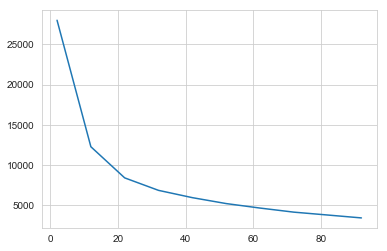

In [20]:
inertia = []
number_k = []
for k in range(2, 100, 10):
    kmeans = KMeans(n_clusters=k).fit(df_norm.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()

While the inertia is still quite high, the clusters are meaningful enough for the analysis I was aiming for, especially given the high dimensionality of the data. Based on where the 'elbow' is, around 20 clusters may be better. 